<a href="https://colab.research.google.com/github/cabb1808/miniproyecto1/blob/main/miniproyecto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
# Descargar datos de GIT
!wget 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv'


--2023-03-24 20:16:05--  https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.3’

housing.csv.3       100%[===================>]   1.36M  --.-KB/s    in 0.06s   

2023-03-24 20:16:05 (23.3 MB/s) - ‘housing.csv.3’ saved [1423529/1423529]



In [64]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.decomposition import SingularSpectrumAnalysis
import scipy.io as sc
from scipy import signal
from ipywidgets import interact
import scipy 
from scipy.stats import entropy
import pandas as pd
import seaborn as sns

In [97]:
ruta_Sismo = 'https://drive.google.com/file/d/1ke7IIRmLWh5-6VmVPVHPoR3P6k4KM_mA/view?usp=sharing'
!gdown  "1ke7IIRmLWh5-6VmVPVHPoR3P6k4KM_mA&confirm=t" -O 'sisLoc.mat' # sismo local
ruta_Sismo = 'https://drive.google.com/file/d/1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI/view?usp=share_link'
!gdown  "1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI&confirm=t" -O 'sisReg.mat' # sismo regional
ruta_Sismo = 'https://drive.google.com/file/d/17BiRodkP3IhzBkWg2b5lHLRBqBMVlDz2/view?usp=sharing'
!gdown  "17BiRodkP3IhzBkWg2b5lHLRBqBMVlDz2&confirm=t" -O 'sisTele.mat' # telesismo

Downloading...
From: https://drive.google.com/uc?id=1ke7IIRmLWh5-6VmVPVHPoR3P6k4KM_mA&confirm=t
To: /content/sisLoc.mat
100% 377k/377k [00:00<00:00, 125MB/s]
Downloading...
From: https://drive.google.com/uc?id=1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI&confirm=t
To: /content/sisReg.mat
100% 1.55M/1.55M [00:00<00:00, 23.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=17BiRodkP3IhzBkWg2b5lHLRBqBMVlDz2&confirm=t
To: /content/sisTele.mat
100% 1.44M/1.44M [00:00<00:00, 129MB/s]


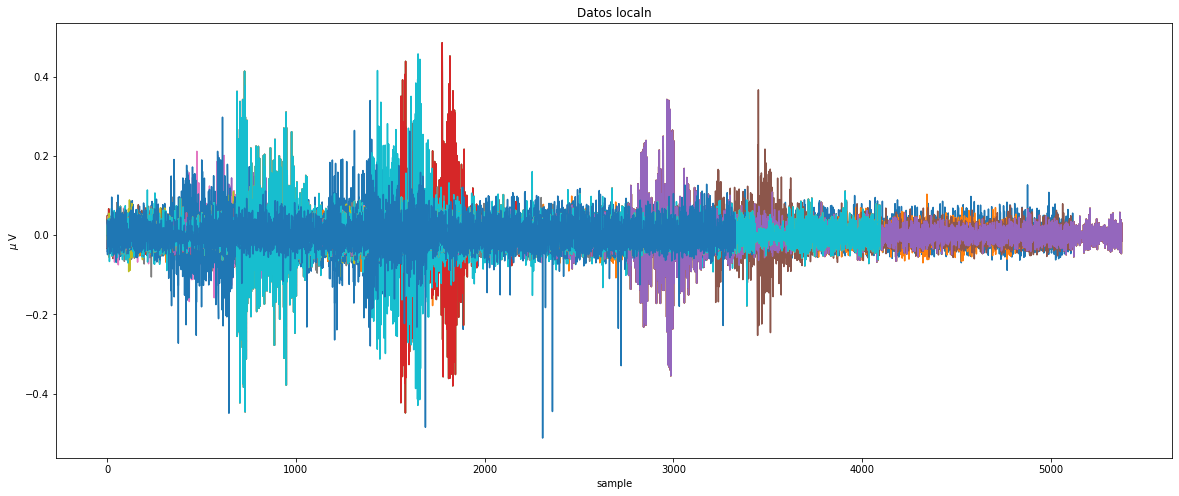

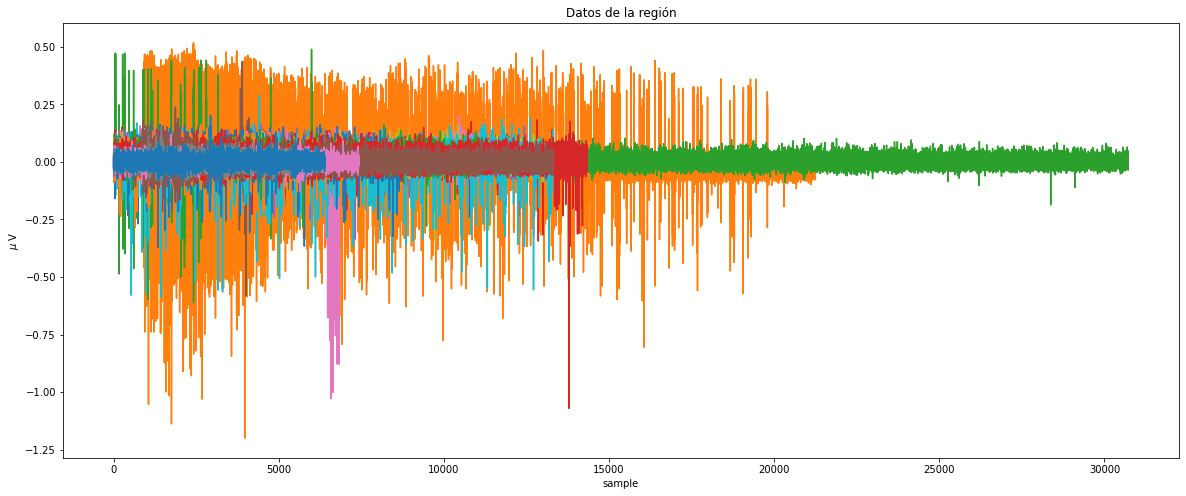

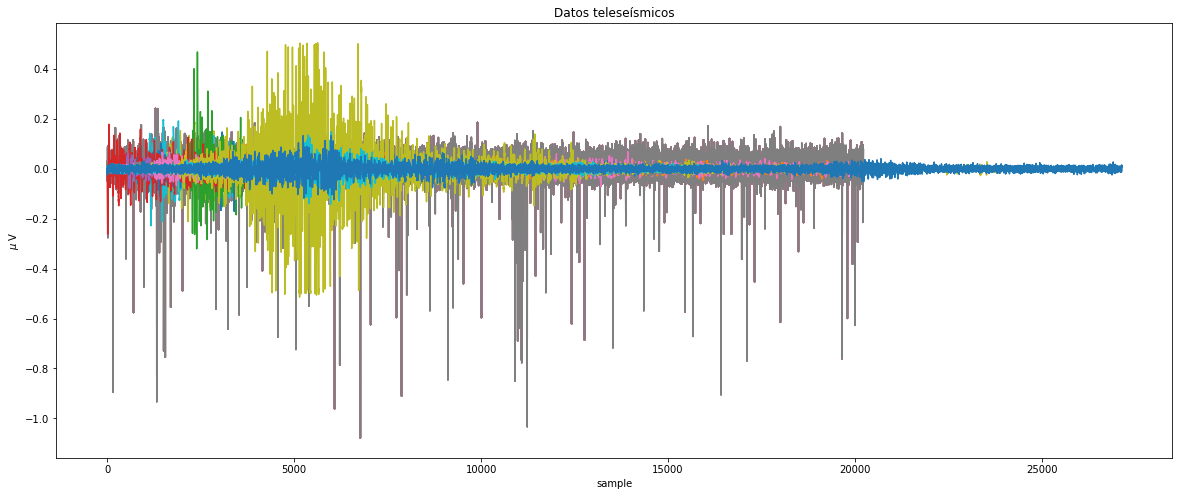

In [98]:
data_local = sc.loadmat('sisLoc.mat')
data_regio = sc.loadmat('sisReg.mat')
data_tele = sc.loadmat('sisTele.mat')

data=[data_local,data_regio,data_tele]
Yd=[]
for d in range(3):
  data[d].keys() # variables del diccionario

  Y = data[d]['Y']
  fs = data[d]['fs'][0][0]


  #Eliminar valores en cero
  Y_L=[]
  for i in range(len(Y)):
    if Y[i][-1] == 0:
      c=0
      for j in range(1,len(Y[i])):
        if Y[i][-j] != 0:
          break
        else: 
          c=c+1
      Y_L.append(Y[i][0:(len(Y[i])-c)])
    else: 
      Y_L.append(Y[i][:])
  

  #Calculamos estadísticas resumidas y graficamos
  plt.figure(figsize=[20,8])
  for i in range(len(Y_L)):
    Y_L[i]=Y_L[i]-np.mean(Y_L[i])
    plt.plot(Y_L[i].T)
  
  Yd.append(Y_L)
  #Agregamos título y leyenda según el conjunto de datos
  if d == 0:
    plt.title('Datos localn')
  elif d == 1:
    plt.title('Datos de la región')
  else:
    plt.title('Datos teleseísmicos')

  plt.xlabel('sample')
  plt.ylabel('$\mu$ V')
  plt.show()

In [99]:
@interact(idx = (0,20,1))

def plotSismos(idx):
  
  sampleSignal = Y_L[idx][:] # se extrae una señal de la base de datos
  plt.figure
  plt.plot(sampleSignal)
  plt.xlabel('sample')
  plt.ylabel('$\mu$ V')
  plt.show()

interactive(children=(IntSlider(value=10, description='idx', max=20), Output()), _dom_classes=('widget-interac…

In [100]:
# Agregar filtro
from scipy.signal import butter, lfilter, freqz


#definimos filtro
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y




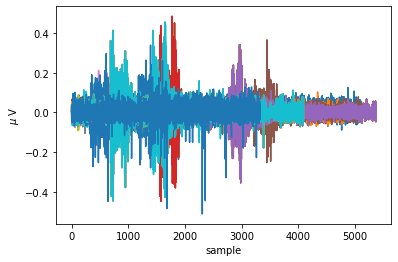

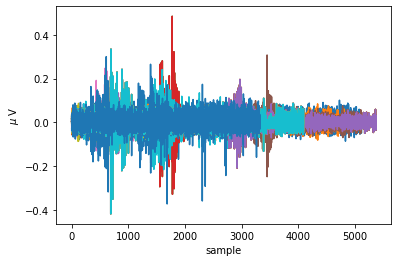

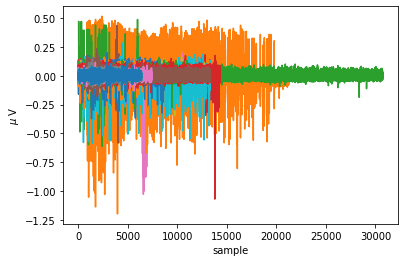

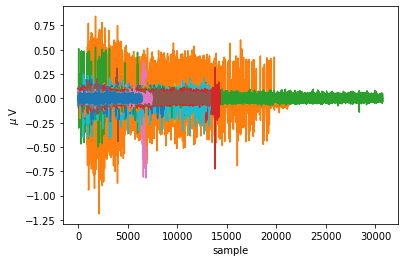

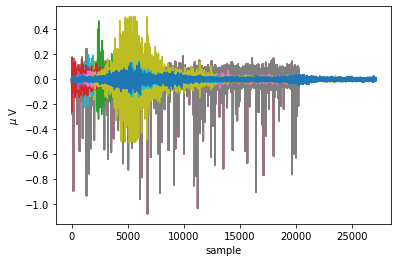

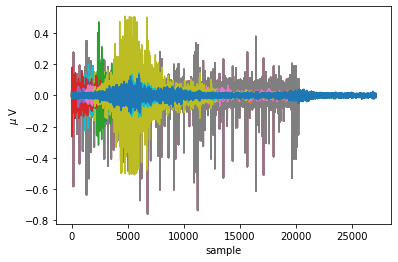

In [101]:
order = 4     
fs=110
cutoff = 50
for d in range(3):
  Y_L=Yd[d]
  Y_Lfilt=[]

  for i in range(len(Y_L)):
    Y_Lfilt.append(butter_lowpass_filter(Y_L[i], cutoff, fs, order))

  for i in range(len(Y_L)):
    plt.plot(Y_L[i].T)
  plt.xlabel('sample')
  plt.ylabel('$\mu$ V')
  plt.show()

  for i in range(len(Y_L)):
    plt.plot(Y_Lfilt[i].T)
  plt.xlabel('sample')
  plt.ylabel('$\mu$ V')
  plt.show()

aca definimos que se puede usar filtro pasabajas o pasabandas, pero elegimos pasabajas porque se ajusta mas al rango deseado de 0-50

para una biografia si es necesario https://www.delftstack.com/es/howto/python/low-pass-filter-python/

In [102]:
print(type(Yd))
print(len(Yd))

print(type(Yd[0]))
print(len(Yd[0]))


<class 'list'>
3
<class 'list'>
21


In [103]:
# We decompose the time series into three subseries
Xssa=[]
for d in range(3):
  X_L = Yd[d] # Conjunto de 21 sismos
  for i in range(21):
    X_L[i] = np.array(X_L[i])
    
  groups = 3

  # Singular Spectrum Analysis
  ssa = SingularSpectrumAnalysis(window_size=groups)
  X_ssa = np.empty(21,dtype=object)  # initialize X_ssa

  for i in range(21):
    X_L_i = X_L[i].reshape(1,-1)  # use the i-th subseries
    X_ssa_i = ssa.fit_transform(X_L_i)
    X_ssa[i]=(X_ssa_i)

    # # Show the results for the first time series and its subseries
    # plt.figure(figsize=(16, 6))
    # idSignal = 3
    # ax1 = plt.subplot(121)
    # ax1.plot(X_L[i], 'o-', label='Original')
    # ax1.legend(loc='best', fontsize=14)

    # ax2 = plt.subplot(122)

    # for j in range(groups):
    #   ax2.plot(X_ssa[i][j], 'o--', label='SSA {0}'.format(i + 1))
    # ax2.legend(loc='best', fontsize=14)

    # plt.suptitle('Singular Spectrum Analysis', fontsize=20)

    # plt.tight_layout()
    # plt.subplots_adjust(top=0.88)
    # plt.show()
  Xssa.append(X_ssa)
print(len(Xssa))
# The first subseries consists of the trend of the original time series.
# The second and third subseries consist of noise.

3


Caracteristicas

In [104]:
def caracteristics(x, fs=110, nperseg=512):
  
  f, t, Zxx = signal.stft(x, fs, nperseg=512)
  energia = np.sum(np.square(x))
  mean = np.mean(np.abs(Zxx))   #media del espectro
  var = np.var(np.abs(Zxx))   #varianza del espectro
  max = np.max(np.abs(Zxx))   #valor maximo del espectro
  min = np.min(np.abs(Zxx))   #valor minimo del espectro

  fpx, px = signal.welch(x, fs=1.0) #potencias y frecuencias
  Pmax = np.max(px)                 #potencia maxima
  Pmax_freq = fpx[np.argmax(px)]    #frecuencia de potencia maxima

  return f, t, Zxx, mean, var, max, min, energia, Pmax, Pmax_freq



def calculate_entropy(list_values):
  value,counter_values = np.unique(list_values, return_counts=True)
  entropyVal = entropy(counter_values, base=None)
  return entropyVal

def calculate_statistics(list_values):
  n5 = np.nanpercentile(list_values, 5)
  n25 = np.nanpercentile(list_values, 25)
  n75 = np.nanpercentile(list_values, 75)
  n95 = np.nanpercentile(list_values, 95)
  median = np.nanpercentile(list_values, 50)
  mean = np.nanmean(list_values)
  std = np.nanstd(list_values)
  var = np.nanvar(list_values)
  rms = np.nanmean(np.sqrt(list_values**2))
  return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
  zero_crossing_indices = np.where(np.diff(np.signbit(list_values)))[0]
  no_zero_crossings = len(zero_crossing_indices)
  mean_crossing_indices = np.where(np.diff(np.signbit(list_values-np.nanmean(list_values))))[0]
  no_mean_crossings = len(mean_crossing_indices)
  return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
  entropy = calculate_entropy(list_values)
  crossings = calculate_crossings(list_values)
  statistics = calculate_statistics(list_values)
  return [entropy] + crossings + statistics

In [105]:
caracteristicas=[np.zeros((21,3,19)) for _ in range(3)]

print(type(Xssa))
print(len(Xssa))

print(type(Xssa[0]))
print(len(Xssa[0]))

print(type(Xssa[0][0]))
print(len(Xssa[0][0]))

print(type(Xssa[0][0][0]))
print(len(Xssa[0][0][0]))

<class 'list'>
3
<class 'numpy.ndarray'>
21
<class 'numpy.ndarray'>
3
<class 'numpy.ndarray'>
5120


In [106]:
for d in range(3):
  X_ssa=Xssa[d]
  for i in range(21):
    for j in range(3):
      f, t, Zxx, mean_spectrum, var_spectrum, max_spectrum, min_spectrum, energy, max_power, max_power_freq = caracteristics(Xssa[d][i][j])
      conjunto1Features = get_features(Xssa[d][i][j])
      caracteristicas[d][i][j]=np.concatenate([np.array([energy, max_power, max_power_freq, mean_spectrum, var_spectrum, max_spectrum, min_spectrum]), conjunto1Features])

In [ ]:
caracteristicas=(np.array(caracteristicas)).reshape(189,19)   #convertir de matriz en vector, y reshape de 189 (21*3)*3

#Agregamos etiquetas

dataframe=pd.DataFrame(caracteristicas,columns=["energy", "max_power", "max_power_freq", "mean_spectrum", "var_spectrum", "max_spectrum", "min_spectrum","entropy","no zero crossing","no mean crossings","n5","n25","n75","n95","median","mean","std","var","rms"])

tag=["Locales"]*63 + ["Regionales"]*63 + ["Telesismo"]*63

dataframe=pd.concat([dataframe,pd.DataFrame(tag,columns=["Type"])],axis=1)

sns.pairplot(dataframe, hue='Type', diag_kind=None, palette='tab10')

KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x7f14c4ab1670> (for post_execute):


KeyboardInterrupt: ignored